In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import math
from math import sqrt
import matplotlib
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import optimizers
import lstm, time

C:\Users\john\AppData\Local\conda\conda\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
f = open('encrypto.csv', 'r').read()
data = f.split('\n')

diff_log = []
for i in range(1, 2640):
    diff_log.append(np.log(float(data[i]))-np.log(float(data[i-1])))

result = []
for i in range(0, 2640 - 240):#240 is the window size
    result.append(diff_log[i: i + 240])#240 is the window size

In [3]:
result_reshape = np.reshape(result, (2640-240,240))
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(result_reshape)
transformed = scaler.transform(result)
#transformed = np.reshape(result, (2640-120,120))

In [4]:
x = []
for i in range(0, 2640 - 240):#240 is the window size
    x.append(transformed[i][0:240-60])#240 is the window size
y = []
for i in range(0, 2640 - 240):#240 is the window size
    y.append(transformed[i][240-60:240])#240 is the window size
x_train = np.reshape(x, (2640-240,240-60,1))#240 is the window size
y_train = np.reshape(y, (2640-240,60))#240 is the window size
x_vali_unshaped = x_train[-1]
x_vali = np.reshape(x_vali_unshaped, (1,240-60,1))#240 is the window size
actual_price = [float(i) for i in (data[2580:2640])]

In [22]:
model = Sequential()
model.add(LSTM(input_dim=1,output_dim=180,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(input_dim=180,output_dim=240,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(input_dim=240,output_dim=360,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(360,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=60))
model.add(Activation('linear'))

start = time.time()
#sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

compilation time :  0.0156252384185791


In [23]:
history = model.fit(x_train,y_train,batch_size=32,nb_epoch=2,validation_split=0.10)

Train on 2160 samples, validate on 240 samples
Epoch 1/2
  96/2160 [>.............................] - ETA: 8:57 - loss: 0.3786

KeyboardInterrupt: 

In [15]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


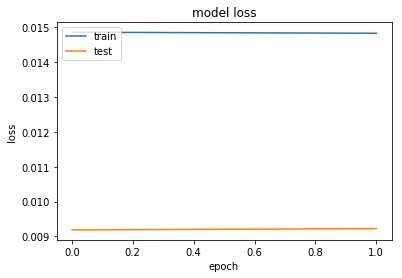

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
predicted = model.predict(x_vali)

In [18]:
predicted_inserted = np.insert(predicted, [0] * (240-60), 0, axis=1)#insert 120(total window size)-60(training window size)
predicted_inverted = scaler.inverse_transform(predicted_inserted)
predicted_fixed = predicted_inverted[0][240-60:240]#120 is total window size

In [19]:
previous_price=[295.1347521]
predicted_price = []
for i in range(0,60):
    predicted_price.append(math.exp(np.log(previous_price)+predicted_fixed[i]))
    previous_price = predicted_price[-1]

In [20]:
rmse = sqrt(sum((np.asarray(predicted_price)-np.asarray(actual_price))**2)/60)
rmse

35.64302733650385

Prediction vs True data


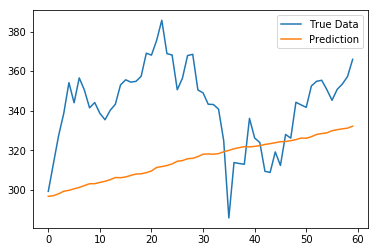

In [21]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(actual_price, label='True Data')
print ('Prediction vs True data')
plt.plot(predicted_price, label='Prediction')
plt.legend()
plt.show()